In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

Let's create a simple wide and deep network with functional API

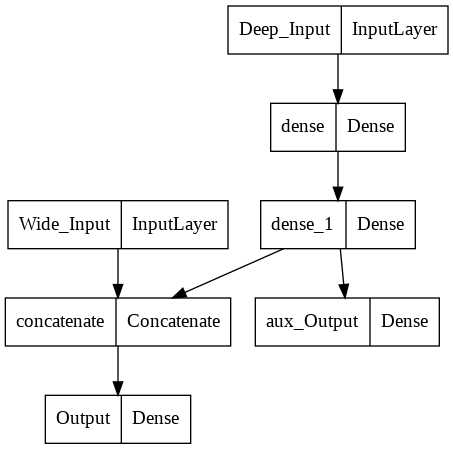

In [ ]:
# define inputs
input_a = Input(shape=[1], name="Wide_Input")
input_b = Input(shape=[1], name="Deep_Input")

# define deep path
hidden_1 = Dense(30, activation="relu")(input_b)
hidden_2 = Dense(30, activation="relu")(hidden_1)

# define merged path
concat = concatenate([input_a, hidden_2])
output = Dense(1, name="Output")(concat)

# define another output for the deep path
aux_output = Dense(1,name="aux_Output")(hidden_2)

# build the model
model = Model(inputs=[input_a, input_b], outputs=[output, aux_output])

# visualize the architecture
plot_model(model)

## Implement as a Class
Alternatively, you can also implement this same model as a class.

For that, you define a class that inherits from the `Model` class. \
Inheriting from the existing `Model` class lets you use the Model methods such as `compile()`, `fit()`, `evaluate()`.
When inheriting from Model, you will want to define at least two functions:

* `__init__()`: you will initialize the instance attributes.
* `call()`: you will build the network and return the output layers.

If you compare the two methods, the structure is very similar, except when using the class, you'll define all the layers in one function, init, and connect the layers together in another function, `call`.

In [2]:
# inherit from the Model base class
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        '''initializes the instance attributes'''
        super().__init__(**kwargs)
        self.hidden1 = Dense(units, activation=activation)
        self.hidden2 = Dense(units, activation=activation)
        self.main_output = Dense(1)
        self.aux_output = Dense(1)

    def call(self, inputs):
        '''defines the network architecture'''
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        
        return main_output, aux_output

In [3]:
model = WideAndDeepModel()

In [4]:
model.layers

In [5]:
model.summary()

ValueError: ignored

In [6]:
tf.ones(2,2)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>

In [7]:
y = model((tf.ones((2,2)), tf.ones((2,2))))

In [8]:
model.summary()

Model: "wide_and_deep_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  90        
                                                                 
 dense_1 (Dense)             multiple                  930       
                                                                 
 dense_2 (Dense)             multiple                  33        
                                                                 
 dense_3 (Dense)             multiple                  31        
                                                                 
Total params: 1,084
Trainable params: 1,084
Non-trainable params: 0
_________________________________________________________________


## Mini ResNet
in this part we want to implement a miniaturized version of ResNet-18. \
for more information about ResNet architecture refer to this [paper](https://arxiv.org/abs/1512.03385) \
Now we want to implement following network:

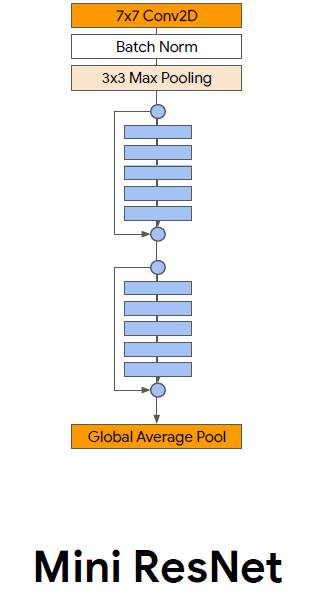

Where each blue block is a residual block as following:

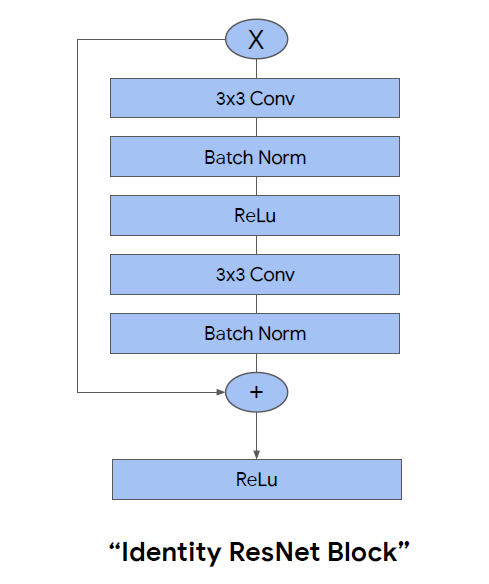

First let's implement the residual block as a seperate layer:

In [9]:
class IdentityBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(IdentityBlock, self).__init__(**kwargs)

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation('relu')

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.add = tf.keras.layers.Add()
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.add([x, inputs])
        x = self.act(x)
        return x

In [10]:
identity_block = IdentityBlock(3, 3)
x_test = tf.random.normal(shape=(8, 224, 224, 3))
y = identity_block(x_test)

Now it's time to implement the whole model.

In [11]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        # Use the Identity blocks that you just defined
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)

        x = self.global_pool(x)
        return self.classifier(x)

## Training the Model
As mentioned before, inheriting the Model class allows you to make use of the other APIs that Keras provides, such as:

* training
* serialization
* evaluation

You can instantiate a Resnet object and train it as usual like below:

In [12]:
import tensorflow_datasets as tfds
# utility function to normalize the images and return (image, label) pairs.
def preprocess(features):
    return tf.cast(features['image'], tf.float32) / 255., features['label']

# create a ResNet instance with 10 output units for MNIST
resnet = ResNet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# load and preprocess the dataset
dataset = tfds.load('mnist', split=tfds.Split.TRAIN, data_dir='./data')
dataset = dataset.map(preprocess).batch(32)

# train the model.
resnet.fit(dataset, epochs=1)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ./data/mnist/3.0.1. Subsequent calls will reuse this data.
1875/1875 [==============================] - 234s 124ms/step - loss: 0.1316 - accuracy: 0.9649


## Model Saving

### Saving Wights

In [13]:
resnet.save_weights('./checkpoints/my_checkpoint')

In [14]:
!ls ./checkpoints

checkpoint  my_checkpoint.data-00000-of-00001  my_checkpoint.index


In [17]:
resnet_new = ResNet(10)

In [19]:
x_test = tf.random.normal(shape=(8, 224, 224, 1))
y = resnet_new(x_test)

In [20]:
resnet_new.load_weights('./checkpoints/my_checkpoint')

### Saving Entire Model

In [21]:
!mkdir -p saved_model
resnet.save('saved_model/my_model')

In [22]:
!ls -ltrh saved_model/my_model/

total 456K
drwxr-xr-x 2 root root 4.0K Aug 21 08:19 variables
drwxr-xr-x 2 root root 4.0K Aug 21 08:19 assets
-rw-r--r-- 1 root root 427K Aug 21 08:19 saved_model.pb
-rw-r--r-- 1 root root  19K Aug 21 08:19 keras_metadata.pb


In [23]:
reconstructed_model = tf.keras.models.load_model("saved_model/my_model")

In [24]:
reconstructed_model.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           multiple                  3200      
                                                                 
 batch_normalization_2 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 identity_block_1 (IdentityB  multiple                 74368     
 lock)                                                           
                                                           